# Evaluation notebook for visualization purposes

In [11]:
from overall_evaluation import overall_evaluation
from LFWEvaluationDataset import LFWEvaluationDataset

import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline


In [12]:
# image_path = overall_evaluation()
# print(image_path)

# create here "overall_evaluation" method
# then wrap it into corresponding python skript
# then call it from main

### Test Dataset class

In [13]:
eval_dataset = LFWEvaluationDataset("./evaluation_data/lfw")

In [14]:
label, image_path = eval_dataset.__getitem__(4)

In [15]:
label

'Aaron_Peirsol'

In [16]:
image_path

'./evaluation_data/lfw\\Aaron_Peirsol\\Aaron_Peirsol_0002.jpg'

### Shuffle Dataset

In [17]:
# divide dataset size by twenty 10, so that processing is faster
subset_size = 10
n_samples = int(eval_dataset.__len__()/subset_size)
print("size of the whole dataset: ", eval_dataset.__len__())
print("size of the reduced dataset: ", n_samples)

# Shuffle indices with np.random.permutation, also fix seed if you want reproducability
shuffled_indices = np.random.RandomState(seed=42).permutation(n_samples)

# select shuffled set from original dataset
eval_dataset_shuffled = torch.utils.data.Subset(eval_dataset, indices=shuffled_indices)
len(eval_dataset_shuffled)

size of the whole dataset:  13233
size of the reduced dataset:  1323


1323

In [18]:
label, image_path = eval_dataset.__getitem__(1)
label

'Aaron_Guiel'

### Create Dataloader

In [19]:
batch_size = 1
eval_loader = torch.utils.data.DataLoader(dataset=eval_dataset_shuffled,
                                           batch_size=batch_size,
                                           num_workers=0,
                                           shuffle=False, 
                                           sampler=None,
                                           collate_fn=None)

('Annie_Machon',)
('Amelie_Mauresmo',)
('Alejandro_Toledo',)
('Aly_Wagner',)
('Abdullah_Nasseef',)
('Alexandre_Despatie',)
(250, 250, 3)


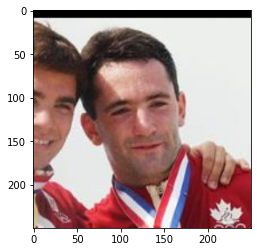

In [20]:
for i, (label, image_path) in enumerate(eval_loader):
    print(label)
    img_pil = Image.open(image_path[0])
    img_numpy = np.array(img_pil)
    plt.imshow(img_numpy)
    if i == 5:
        print(img_numpy.shape)
        break

**All tensor shapes for input are 1x3x250x250**

### For-loop: Feed each image through pipeline

In [21]:
# 2. Pass image through whole pipeline (detection & alignment # embedding)
# 3. Try to recognize person and then adapt TA, TR, ... (for first person, directly register --- for first people, use fixed threshold)
# 4. Register person to database
# print every 1000 images intermediate results

In [22]:
from deepface import DeepFace
from faceEmbeddingModel import faceEmbeddingModel
from reg_database import RegistrationDatabase

Using TensorFlow backend.
C:\Users\Marco\AppData\Roaming\Python\Python37\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Marco\AppData\Roaming\Python\Python37\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Marco\AppData\Roaming\Python\Python37\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Us

In [23]:
def green_print(line):
    print('\033[92m'+line+'\033[0m')

In [24]:
def calculate_error(fa, fr, wa, accept, reject):
    if accept > 0:
        # false accept rate -> as low as possible
        far = float(fa/accept)
        # wrong accept rate -> as low as possible
        war = float(wa/accept)
    else:
        far = 0
        war = 0

    if reject > 0:
        # false reject rate -> as low as possible
        frr = float(fr/reject)
    else:
        frr = 0
    
    error = (fa+fr+wa)/(accept+reject)
    return far, frr, war, error

In [25]:
def show_and_save(fa, fr, wa, accept, reject, filepath):
    # Calculate error
    far, frr, war, error = calculate_error(fa, fr, wa, accept, reject)

    # String formatting: every %f oder %d is an index in the following tuple (f: float, d: double?)
    # String formatting not recommended!!
    info = 'far:%f(%d/%d), frr:%f(%d/%d), war:%f(%d/%d), acc:%.4f(%d/%d)\n' % \
            (far, fa, accept, frr, fr, reject, 
            war, wa, accept, 1-error, (accept+reject)-(fa+fr+wa), (accept+reject))
    # Print result
    green_print(info)
    # Save result
    with open(filepath, 'a') as file:
        file.write(info)
    return filepath

In [30]:
# Initialize
filepath = "./evaluation_results/first_tests.txt"
embedding_model = faceEmbeddingModel().eval()

# mode='euclidean_distance'
database = RegistrationDatabase()
database.clean_database()

fa = 0  # False accept
wa = 0  # Wrong answer
fr = 0  # False reject
accept = 0
reject = 0

for i, (label, image_path) in enumerate(eval_loader):
    label = label[0]
    # Face Detection and alignemnt
    detected_face_numpy = DeepFace.detectFace(image_path[0])
    
    # Reshape output
    detected_face = detected_face_numpy.copy()
    # Afterwards: Pytorch tensor 1x3x250x250
    detected_face = torch.from_numpy(detected_face).permute(2,0,1).unsqueeze(0)
    # print(detected_face.shape)
    #plt.imshow(detected_face.permute(1, 2, 0))
    
    # Face Embedding
    embedding = embedding_model(detected_face)
    
    # Face Recognition (No face recognition for first person, as no faces registered so far)
    if i > 0:
        closest_label, check = database.face_recognition(embedding)
#         print("True label: ", label)    
#         print("Predicted label:", closest_label, " --- Access?: ", check)
#         print("-----------------")
        
        # Allegedly known
        if check == 'Access':
            accept += 1
            if not database.contains(closest_label):
                fa += 1  # False accept
            elif closest_label != label:
                wa += 1  # Recognition error
            
        # Allegedly Intruder
        if check == 'Decline':
            reject += 1
            if database.contains(closest_label):
                fr += 1  # False reject
    
    # Face Registration (only if label not already in database, as one-shot learning)
    if not database.contains(label):
        database.face_registration(label,embedding)
        
    if (i > 0) and (i % 100 == 0):      
        # Calculate error
        result_file = show_and_save(fa, fr, wa, accept, reject, filepath)
        #return result_file
    

Database already exists. Pickle file will be loaded...
database.pkl exists and will be cleaned...
far:0.000000(0/56), frr:1.000000(44/44), war:0.910714(51/56), acc:0.0500(5/100)



ValueError: ('Detected face shape is ', (138, 0, 3), '. Consider to set enforce_detection argument to False.')

In [ ]:
database.database